This data was obtained from MR images ,then annotated and augmented. Binary masks contain only brain tissue, excluding the tumor tissue.

I have used the following methods.

- Unet architecture with elu activation function,
- Dice coefficient implementation,
- The project took place using Google TPU

In [1]:
# Importing dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D,UpSampling2D, Dropout, MaxPooling2D, concatenate, Lambda, BatchNormalization

In [2]:
# Connecting TPU and creating strategy and the model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

In [3]:
# Loading brain images and correspondent binary masks

X = np.load('/content/drive/MyDrive/Colab Notebooks/brain_tumor/X_train_anormallik.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/brain_tumor/Y_train_anormallik.npy')
X_t = np.load('/content/drive/MyDrive/Colab Notebooks/X_test.npy')


X_train = X[:,:,:,0]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2], 1 )


y_train = y[:,:,:,0]
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],y_train.shape[2], 1 )
y_train = y_train.astype('float32')


X_test = X_t[:,:,:,0]
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2], 1 )



In [4]:
print("train images ", X_train.shape[0])
print("test images ", X_test.shape[0])

train images  2268
test images  1440


In [5]:
def create_random_image_and_mask(image, mask,  cmap1 = 'gray', cmap2 = 'gray'):
  idx = random.randint(0, image.shape[0]-1)

  plt.figure(dpi = 150)

  plt.subplot(121)
  plt.imshow(image[idx], cmap =  cmap1)
  plt.title("Original image " + str(idx))

  plt.subplot(122)
  plt.imshow(mask[idx], cmap = cmap2)
  plt.title("Mask")


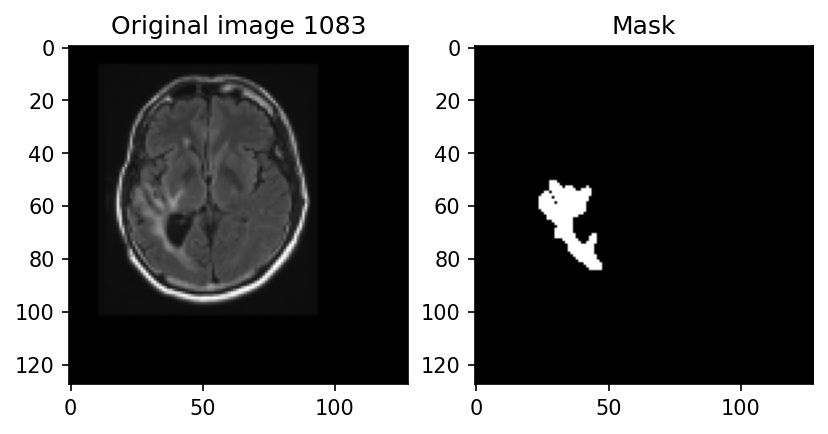

In [7]:
create_random_image_and_mask(X_train, y_train)

In [8]:
# Creating a convolution block builder

def conv_block(filter_size, kernel_size, padding = 'same', kernel_init = 'he_normal', activation = 'relu'):

  def make(inputs):
    features = Conv2D(filters = filter_size, kernel_size = kernel_size, padding=padding, kernel_initializer = kernel_init, activation = activation )(inputs)
    features = Conv2D(filters = filter_size, kernel_size = kernel_size, padding=padding, kernel_initializer = kernel_init )(features)

    return features

  return make



In [9]:
# Creating Dice metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [18]:
# Creating U-Net model

with strategy.scope():

  inp = Input(shape = (128, 128,1))
  L =  Lambda(lambda x: x / 255.0)(inp)

  C0 = conv_block(32, 3 ,activation = 'elu' )(L)
  M0 = MaxPooling2D(2)(C0)


  C1 = conv_block(64, 3,activation = 'elu'  )(M0)
  M1 = MaxPooling2D(2)(C1)

  C2 = conv_block(128, 3 ,activation = 'elu' )(M1)
  M2 = MaxPooling2D(2)(C2)

  C3 = conv_block(256, 3 ,activation = 'elu' )(M2)
  M3 = MaxPooling2D(2)(C3)

  C4 = conv_block(512, 3 ,activation = 'elu' )(M3)
  D4 = Dropout(0.4)(C4)
  M4 = MaxPooling2D(2)(D4)

  C5 = conv_block(1024, 3 ,activation = 'elu'  )(M4)
  D5 = Dropout(0.4)(C5)

  UP6 = UpSampling2D(size = (2,2))(D5)
  UP6 = Conv2D(512, 2, activation = 'elu', padding = 'same', kernel_initializer = 'lecun_normal')(UP6)
  MERG6 = concatenate([D4, UP6], axis = 3)
  C6 = conv_block(512, 3 )(MERG6)


  UP7 = UpSampling2D(size = (2,2))(C6)
  UP7 = Conv2D(256, 2, activation = 'elu', padding = 'same', kernel_initializer = 'lecun_normal')(UP7)
  MERG7 = concatenate([C3, UP7], axis = 3)
  C7 = conv_block(256, 3)(MERG7)


  UP8 = UpSampling2D(size = (2,2))(C7)
  UP8 = Conv2D(128, 2, activation = 'elu', padding = 'same', kernel_initializer = 'lecun_normal')(UP8)
  MERG8 = concatenate([ C2, UP8], axis = 3)
  C8 = conv_block(128, 3)(MERG8)


  UP9 = UpSampling2D(size = (2,2))(C8)
  UP9 = Conv2D(64, 2, activation = 'elu', padding = 'same', kernel_initializer = 'lecun_normal')(UP9)
  MERG9 = concatenate([ C1, UP9], axis = 3)
  C9 = conv_block(64, 3 )(MERG9)


  UP10 = UpSampling2D(size = (2,2))(C9)
  UP10 = Conv2D(32, 2, activation = 'elu', padding = 'same', kernel_initializer = 'lecun_normal')(UP10)
  MERG10 = concatenate([ C0,UP10 ], axis = 3)
  C10 = conv_block(32, 3 )(MERG10)


  C11 = Conv2D(16, 3, activation = 'elu', padding = 'same', kernel_initializer = 'lecun_normal')(C10)

  out = Conv2D(1, 1, activation = 'sigmoid')(C11)

  model = tf.keras.Model(inputs = inp, outputs = out)

  my_callbacks = [tf.keras.callbacks.EarlyStopping(min_delta = 0.00001 , patience = 20, monitor = 'val_dice_coef') ]

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6) ,  loss = 'binary_crossentropy' , metrics = [dice_coef])
  hist = model.fit(X_train, y_train, validation_split=0.2 , batch_size = 16, epochs = 300 )


Epoch 1/300
114/114 [==============================] - 44s 108ms/step - loss: 0.2694 - dice_coef: 0.0393 - val_loss: 0.1745 - val_dice_coef: 0.0994
Epoch 2/300
114/114 [==============================] - 6s 53ms/step - loss: 0.1202 - dice_coef: 0.0969 - val_loss: 0.1309 - val_dice_coef: 0.1288
Epoch 3/300
114/114 [==============================] - 6s 55ms/step - loss: 0.0942 - dice_coef: 0.1323 - val_loss: 0.1183 - val_dice_coef: 0.1482
Epoch 4/300
114/114 [==============================] - 6s 54ms/step - loss: 0.0831 - dice_coef: 0.1602 - val_loss: 0.1157 - val_dice_coef: 0.1649
Epoch 5/300
114/114 [==============================] - 6s 54ms/step - loss: 0.0762 - dice_coef: 0.1876 - val_loss: 0.1170 - val_dice_coef: 0.1870
Epoch 6/300
114/114 [==============================] - 6s 53ms/step - loss: 0.0718 - dice_coef: 0.2096 - val_loss: 0.1145 - val_dice_coef: 0.2003
Epoch 7/300
114/114 [==============================] - 6s 52ms/step - loss: 0.0686 - dice_coef: 0.2312 - val_loss: 0.1191 

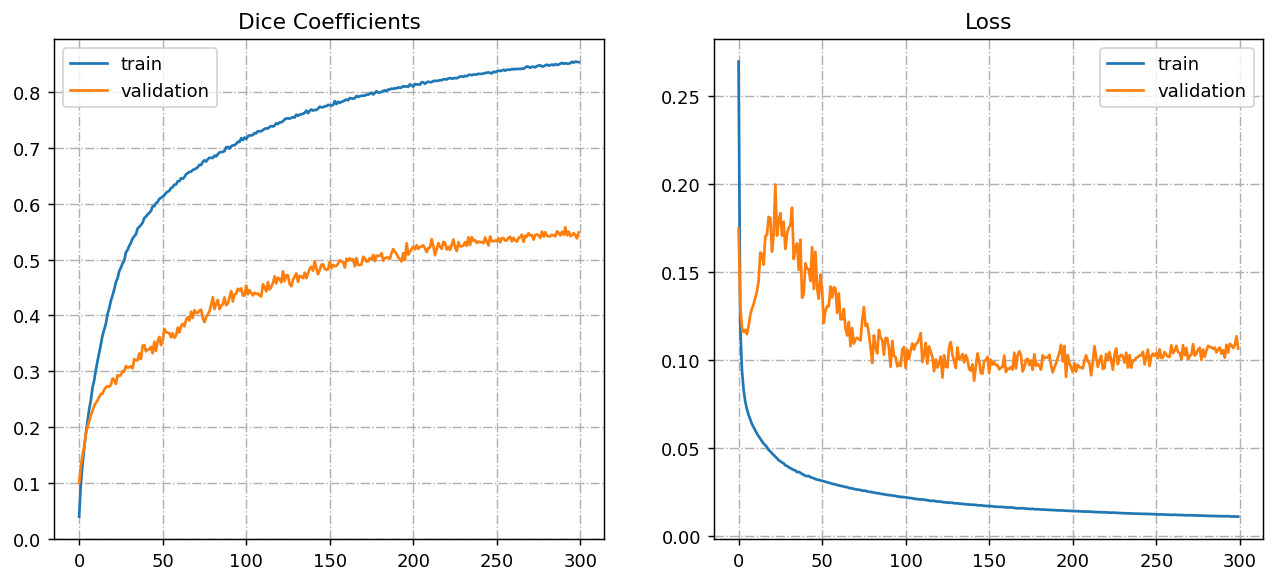

In [19]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Dice Coefficients")
axs[0].plot(hist.history['dice_coef'])
axs[0].plot(hist.history['val_dice_coef'])
axs[0].legend(["train", "validation"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Loss")
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].legend(["train", "validation"])

In [20]:
# Prediction

pred = model.predict(X_test, verbose=1)

threshold  = pred.mean() + pred.std()
bitmap_preds = (pred > threshold).astype(np.uint8)

45/45 [==============================] - 6s 115ms/step


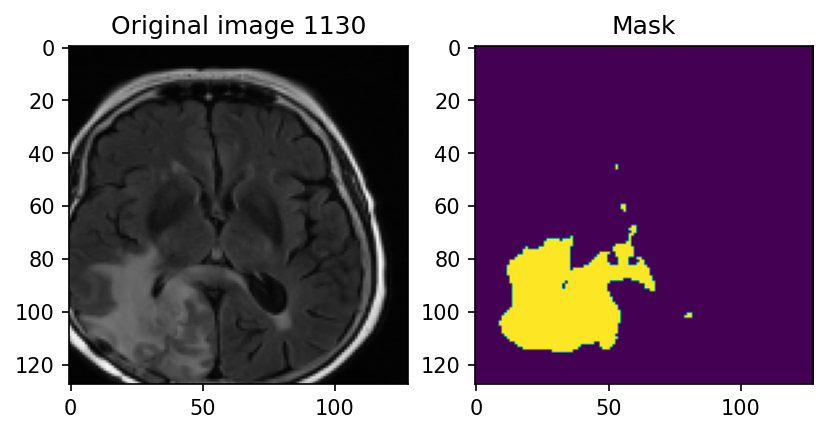

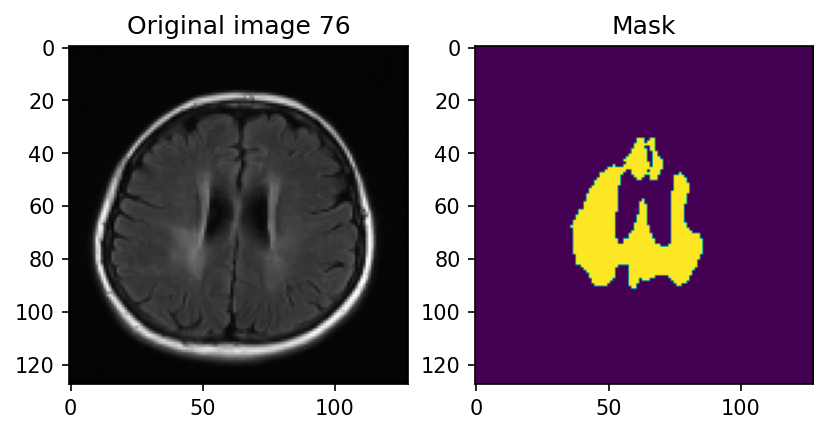

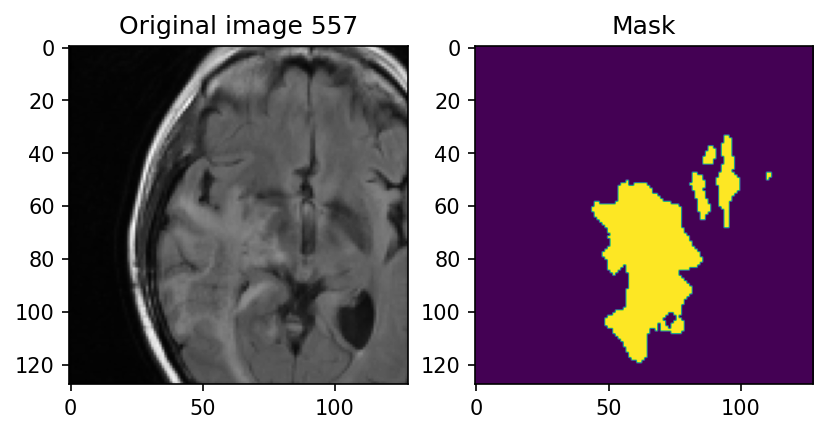

In [25]:
# Test samples and their prediction masks

create_random_image_and_mask(X_test,bitmap_preds, cmap2 = None)
create_random_image_and_mask(X_test,bitmap_preds, cmap2 = None)
create_random_image_and_mask(X_test,bitmap_preds, cmap2 = None)
